<a href="https://colab.research.google.com/github/Sakshikaradi/clinicooo/blob/main/clinicooo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Data Preparation

In [1]:

import os
import cv2
import pandas as pd
# import pydicom
!pip install pydicom

def dicom_to_png(dicom_path, png_path):
    try:
        dcm = pydicom.dcmread(dicom_path)
        img = dcm.pixel_array
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        cv2.imwrite(png_path, img)
    except Exception as e:
        print(f"Error converting {dicom_path} to PNG: {e}")

def convert_dataset(dicom_dir, out_dir, csv_annotations):
    os.makedirs(out_dir, exist_ok=True)

    # Load CSV
    annots = pd.read_csv(csv_annotations)

    for i, row in annots.iterrows():
        image_id = row['image_id']
        dicom_file = os.path.join(dicom_dir, image_id + ".dicom")
        png_file = os.path.join(out_dir, image_id + ".png")

        if os.path.exists(dicom_file):
            dicom_to_png(dicom_file, png_file)
        else:
            print(f"Missing DICOM file: {dicom_file}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.8 MB/s eta 0:00:00


In [ ]:
# Classification Dataset

In [2]:

import torch
from torch.utils.data import Dataset
from PIL import Image

class ClassificationDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __lengh__(self):
        return lengh(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# Classification Model

In [3]:

import torch.nn as nn
import torchvision.models as models

def build_resnet(num_classes, pretrained=True):

    model = models.resnet50(pretrained=pretrained)

    # Replace the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),
        nn.Linear(512, num_classes),
        nn.Sigmoid()  # Use sigmoid for multi-label classification
    )

    return model


In [ ]:
# Training

In [4]:

from google.colab import drive
import os

# 🔗 Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 📁 Define dataset path
dataset_path = "/content/drive/MyDrive/chest_xray_data/chest_xray"

# ✅ Check dataset path and list structure
if os.path.exists(dataset_path):
    print("✅ Dataset path found!")

    print("📂 Dataset structure (first 40 files/folders):\n")
    for root, dirs, files in os.walk(dataset_path):
        print(f"📁 {root}")
        for name in dirs[:10]:  # Show only first 10 directories per level
            print(f"  ┣━ 📂 {name}")
        for name in files[:10]:  # Show only first 10 files per level
            print(f"  ┣━ 📄 {name}")
        print("-" * 40)
        break  # Limit to top level only
else:
    print("❌ Dataset path not found. Please double-check the Google Drive path.")


Mounted at /content/drive
✅ Dataset path found!
📂 Dataset structure (first 40 files/folders):

📁 /content/drive/MyDrive/chest_xray_data/chest_xray
  ┣━ 📂 __MACOSX
  ┣━ 📂 train
  ┣━ 📂 chest_xray
  ┣━ 📂 test
  ┣━ 📂 val
  ┣━ 📄 train.csv.zip
----------------------------------------


In [ ]:
# Detection Model

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
📷 Using sample image: /content/drive/MyDrive/chest_xray_data/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


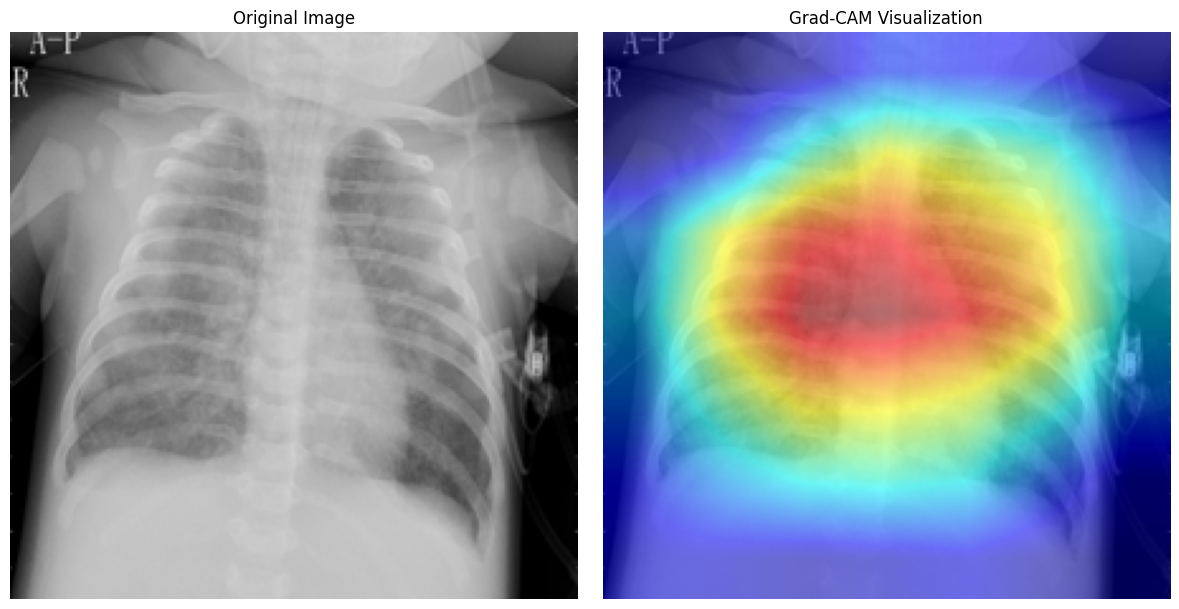

In [5]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install -q grad-cam

import os
import random
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


# 🔗 Dataset path
dataset_path = "/content/drive/MyDrive/chest_xray_data/chest_xray/val/PNEUMONIA"

# 📸 Select a random image
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not image_files:
    raise FileNotFoundError("❌ No image files found in the dataset path!")

sample_image = random.choice(image_files)
sample_image_path = os.path.join(dataset_path, sample_image)
print(f"📷 Using sample image: {sample_image_path}")

# 🖼️ Load and preprocess image
img = Image.open(sample_image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# 🤖 Load pretrained model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

# 🔍 Grad-CAM setup
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 📊 Compute Grad-CAM
rgb_img = np.array(img.resize((224, 224))) / 255.0
grayscale_cam = cam(input_tensor=input_tensor)[0]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# 📈 Show side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(rgb_img)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(visualization)
ax2.set_title('Grad-CAM Visualization')
ax2.axis('off')

plt.tight_layout()
plt.show()


In [6]:
!pip install streamlit
!pip install pyngrok

!pip install -q streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.0 MB/s eta 0:00:00


In [ ]:
# Deployment model

In [8]:

%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

@st.cache_resource
def load_model():
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load("model.pth", map_location="cpu"))
    model.eval()
    return model

model = load_model()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

st.title(" Clinicooo")
st.write("🚀 Deployment successful!")

class_names = ["Normal", "Pneumonia"]

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    try:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Uploaded Image", use_column_width=True)

        input_tensor = transform(image).unsqueeze(0)

        with st.spinner("Running inference..."):
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)[0]
                pred_class = torch.argmax(probs).item()

        st.markdown(f"### Prediction: **{class_names[pred_class]}**")
        st.markdown(f"Confidence: **{probs[pred_class].item()*100:.2f}%**")

        # Horizontal bar chart for readability
        st.bar_chart({
            class_names[i]: probs[i].item() for i in range(len(class_names))
        }, use_container_width=True)

    except Exception as e:
        st.error(f"Error processing image: {e}")

else:
    st.info("Please upload an image to get started.")


Overwriting app.py
